In [2]:
import jax
import jax.numpy as jnp
import croissant as cro
import croissant.jax as crojax
import matplotlib.pyplot as plt
from functools import partial
from healpy import get_nside, projview
import numpy as np
import lunarsky
import s2fft
import healpy as hp
from lunarsky import Time
from astropy.units import s as seconds
from tqdm.notebook import trange

fatal: No names found, cannot describe anything.


In [5]:
world = "earth"
lmax = 64 # maximal harmonic band limit given sampling of beam, inclusive
# freq = jnp.arange(50, 251)
ntimes = 10
dt = cro.constants.sidereal_day[world] / ntimes
phases = crojax.simulator.rot_alm_z(lmax, ntimes, dt, world=world)

PATH = "/home/christian/Documents/research/eigsep/DAC"

data = jnp.load(f'{PATH}/eigsep_vivaldi.npz')

vivaldi_hp = data['bm']
freq = data['freqs']/1e6
nside = 32
vivaldi_hp = hp.ud_grade(vivaldi_hp, nside, power=-2)
npix = hp.nside2npix(nside)

fmin = 50
fmax = 51
fcut = (freq >= fmin) * (freq <= fmax)

vivaldi_hp = vivaldi_hp[fcut]
freq = freq[fcut]

print(freq.shape, vivaldi_hp.shape)

(2,) (2, 12288)


In [25]:
beam2alm = partial(s2fft.forward_jax, L=lmax+1, spin=0, nside=nside, sampling="healpix", reality=True)
beam_alm_v = jax.vmap(beam2alm)(vivaldi_hp)
new_lmax = 16
beam_alm_v = beam_alm_v[:, :new_lmax, lmax+1-new_lmax:lmax+1+new_lmax]
norm = crojax.alm.total_power(beam_alm_v, new_lmax)

sky_map = jnp.full((freq.size, npix), 300)
sky_map = sky_map.at[:, 100:200].add(1000)
sky2alm = partial(s2fft.forward_jax, L=lmax+1, spin=0, nside=nside, sampling="healpix", reality=True)
sky_alm = jax.vmap(sky2alm)(sky_map)
sky_alm = sky_alm[:, :new_lmax, lmax+1-new_lmax:lmax+1+new_lmax]
vis = crojax.simulator.convolve(beam_alm_v, sky_alm, phases).real / norm
print(norm)

TypeError: mul got incompatible shapes for broadcasting: (1, 2, 16, 32), (10, 1, 1, 129).

(2, 65, 129)

(2, 65, 129)
[10.0047899  10.10443863]
pre waterfall
post waterfall


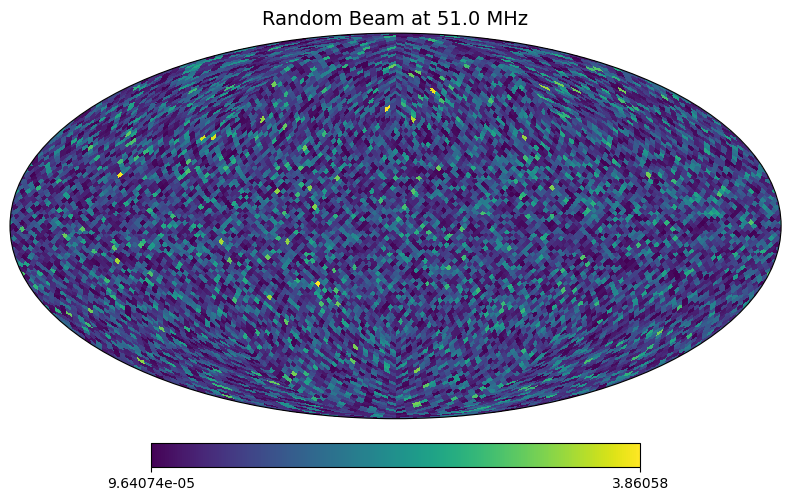

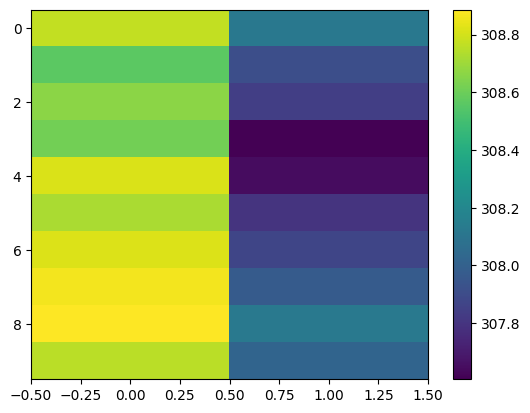

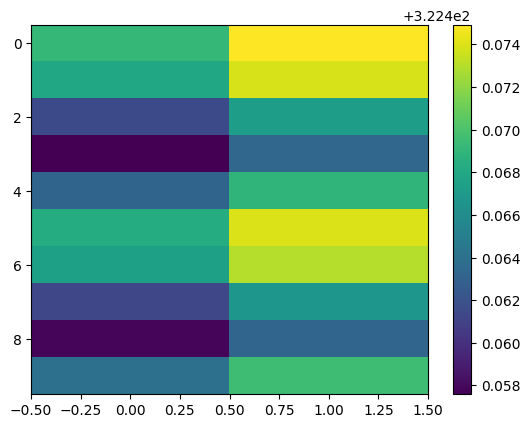

In [7]:
key = jax.random.PRNGKey(42)
random_beam = jnp.abs(jax.random.normal(key, shape = (vivaldi_hp.shape)))

def water_maker(beam):
    beam_alm = jax.vmap(beam2alm)(beam)
    print(beam_alm.shape)
    # print(jnp.max(beam_alm))
    norm = crojax.alm.total_power(beam_alm, lmax)
    print(norm)
    print('pre waterfall')
    waterfall = crojax.simulator.convolve(beam_alm, sky_alm, phases).real / norm
    print('post waterfall')
    return waterfall


projview(m=random_beam[1], title=f"Random Beam at {freq[1]} MHz")
plt.figure()
plt.imshow(water_maker(random_beam), aspect='auto')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(vis, aspect='auto')
plt.colorbar()

plt.show()

In [8]:
@jax.jit
def loss_fcn(beam):
    fit = water_maker(beam)
    return jnp.sum(jnp.abs(vis**2 - fit**2)) / beam.size

loss_grad = jax.grad(loss_fcn)

In [20]:
#p0 = jnp.full(random_beam.shape, 300, dtype=jnp.float64)



def fit(max_iter, learning_rate, initial_beam=random_beam):
    """
    The fitting loop.

    Parameters
    ----------
    max_iter : int
        Number of iterations in the loop.
    learning_rate : float
        Hyperparameter that sets the step size (how much we update the parameters at each step)
    initial_par : ndarray
        The initial guess for the parameters.

    Returns
    -------
    par_vals : ndarray
        The parameter at each iteration.
    loss_vals : ndarray
        The value of the loss at each iteration.
    grad_vals : ndarray
        The value of the gradient of the loss at each iteraiton.
    
    """
    beams = []
    loss_vals = []
    grad_vals = []

    beam = initial_beam
    
    for step in trange(max_iter):
        # my_beam = beam_maker(random_beam, par)
        loss = loss_fcn(beam)
        # print('loss')
        grad = loss_grad(beam)
        # print('grad')
        loss_vals.append(loss)
        grad_vals.append(grad)
        beam -= learning_rate * grad
        # print('par shape', par.shape)
        beams.append(beam)
        # my_beam = beam_maker(random_beam, par)

    beams = jnp.array(beams)
    loss_vals = jnp.array(loss_vals)
    grad_vals = jnp.array(grad_vals)
    return beams, loss_vals, grad_vals

# param_list = []
# lost_list = []

# for i in range(ntimes):
#     par_vals, loss_vals, grad_vals = fit(2, .0001, i, p0)
#     param_list.append(par_vals)
#     lost_list.append(loss_vals)
    
# param_arr = jnp.array(param_list)
# lost_arr = jnp.array(lost_list)
# print(param_arr.shape, lost_arr.shape)
par_vals, loss_vals, grad_vals = fit(500, 1)

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
jnp.savez("results.npz", par_vals=par_vals, loss_vals=loss_vals, grad_vals=grad_vals)

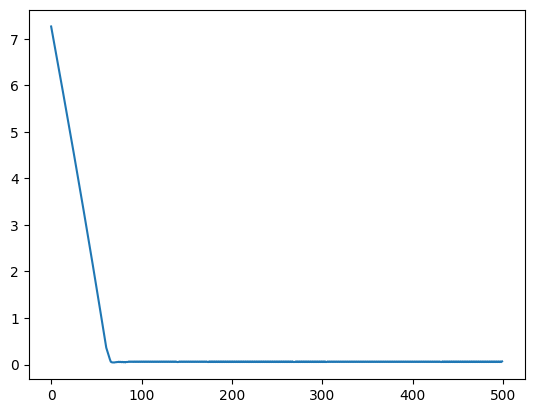

In [21]:
plt.figure()
plt.plot(loss_vals)
plt.show()

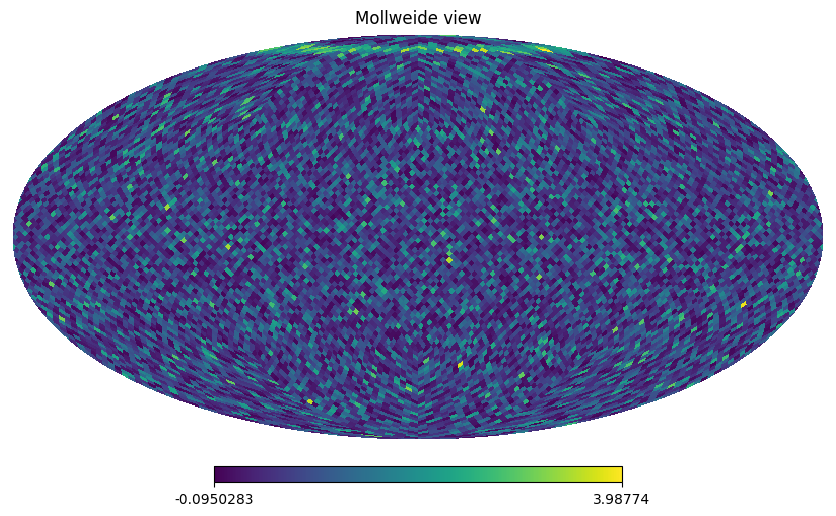

In [23]:
hp.mollview(par_vals[90][0])